In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Stijnvhd/AutoML_DL_Course/main/Data/titanic_dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.drop("PassengerId", axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)
gender_mapper = {'male': 0, 'female': 1}
df['Sex'].replace(gender_mapper, inplace=True)
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].strip().split(' ')[0])
df['Title'] = [0 if x in ['Mr.', 'Miss.', 'Mrs.'] else 1 for x in df['Title']]
df = df.rename(columns={'Title': 'Title_Unusual'})
df.drop('Name', axis=1, inplace=True)
df['Cabin_Known'] = [0 if str(x) == 'nan' else 1 for x in df['Cabin']]
df.drop('Cabin', axis=1, inplace=True)
emb_dummies = pd.get_dummies(df['Embarked'], drop_first=True, prefix='Embarked')
df = pd.concat([df, emb_dummies], axis=1)
df.drop('Embarked', axis=1, inplace=True)
df['Age'] = df['Age'].fillna(int(df['Age'].mean()))

In [4]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Unusual,Cabin_Known,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,0,0,1
1,1,1,1,38.0,1,0,71.2833,0,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,1,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,1,0,0,1
887,1,1,1,19.0,0,0,30.0000,0,1,0,1
888,0,3,1,29.0,1,2,23.4500,0,0,0,1
889,1,1,0,26.0,0,0,30.0000,0,1,0,0


In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

In [5]:
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [6]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

# TPOT

We can perform both classification as regression with TPOT. However, both come with the same 4 functions for us to use:

fit(features, target): Run the TPOT optimization pipeline on the given data.

predict(features): Use the optimized pipeline to predict the target values of an example/examples of features set.

score(test_features, test_target): evaluate the model on test data and returns the most optimized score generated

export(output_file_name): export the optimized pipeline as python code.

## Classification

generations: number of iterations to run pipeline process (default: 100).

population_size: number of individuals to retain genetic programming population every generation ( default 100).

offspring_size: number of offspring to generate in each genetic programming iteration. (default 100).

mutation_rate: mutation rate b/w [0,1] (default 0.9)

crossover_rate: crossover rate b/w [0,1] (default 0.1) {mutation rate + crossover_rate <= 1}.

scoring: metrics for evaluating the quality of the pipeline. Here scoring takes parameters such as Accuracy, F1 score etc

cv: cross-validation method, if the given value is Integer, then it will be K in K-Fold cross-validation.

n_job: number of processes that can be run in parallel (default 1).

max_time_mins: maximum time Tpot allowed optimizing the pipeline (default: None).

max_eval_time_mins: How many minutes TPOT has to evaluate a single pipeline(default: None).

verbosity: How much information TPOT displays while it’s running. {0: nothing, 1: minimal information, 2: more information and progress bar, 3: everything} (default: 0)

In [7]:
from tpot import TPOTClassifier
tpot = TPOTClassifier(verbosity=2, max_time_mins=10)
tpot.fit(X_train_scaled, y_train)

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8300009849305624

Generation 2 - Current best internal CV score: 0.8356150891362158

Generation 3 - Current best internal CV score: 0.8356150891362158

Generation 4 - Current best internal CV score: 0.8356150891362158

10.01 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: MLPClassifier(BernoulliNB(input_matrix, alpha=0.01, fit_prior=False), alpha=0.0001, learning_rate_init=0.001)


TPOTClassifier(max_time_mins=10, verbosity=2)

In [8]:
tpot.fitted_pipeline_

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=BernoulliNB(alpha=0.01,
                                                         fit_prior=False))),
                ('mlpclassifier', MLPClassifier())])

In [9]:
tpot.score(X_test_scaled, y_test)

0.8044692737430168

How does the TPOT classifier work? It makes use of a tree-based structure to represent a model pipeline which includes data preparation, modeling algorithms and model hyperparameters. Through an optimization procedure, a tree structure is searched which offers the best possible model. 

As you can see, the use of the TPOT library is very straight forward and easy to do. We can also add an extra cross-validation class. This can be a RepeatedKFold for regression or a RepeatedStratefiedKFold for classification. 

In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
tpot2 = TPOTClassifier(verbosity=2, generations=5, population_size=50, scoring='accuracy', cv=cv)
tpot2.fit(X_train_scaled, y_train)

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8244392279603547

Generation 2 - Current best internal CV score: 0.8305881585811166

Generation 3 - Current best internal CV score: 0.8305881585811166

Generation 4 - Current best internal CV score: 0.831964006259781

Generation 5 - Current best internal CV score: 0.8352243088158581

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=3, min_samples_split=13, n_estimators=100)


TPOTClassifier(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
               generations=5, population_size=50, scoring='accuracy',
               verbosity=2)

In [14]:
tpot2.fitted_pipeline_

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_features=0.35000000000000003,
                                        min_samples_leaf=3,
                                        min_samples_split=13))])

In [15]:
tpot2.score(X_test_scaled, y_test)

0.8100558659217877

The model we achieve in the end has a mean accuracy score of 83.5 % on the validation set and when we test it out on our test set, we can clearly see a performance of 81%. This shows a very high performance. If we want to store the model, we can save it to a .py file as we will see a bit later on

## Regression

Most of the arguments are common to above describe TpotClassifier. Here the only parameter which is different is scoring. In TpotRegression, we need to evaluate the regression, so we use parameters such as: ‘neg_median_absolute_error’, ‘neg_mean_absolute_error’, ‘neg_mean_squared_error’, ‘r2’

In [3]:
df_regression = pd.read_csv('https://raw.githubusercontent.com/Stijnvhd/AutoML_DL_Course/main/Data/kc_house_data.csv')
df_regression.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
import sweetviz as sv

my_report = sv.analyze(df)
my_report.show_html()

In [6]:
from sklearn.model_selection import RepeatedKFold
from tpot import TPOTRegressor

X = df_regression.drop(['price', 'date', 'id'], axis=1)
y = df_regression['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
# define evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search
model = TPOTRegressor(generations=5, population_size=50, scoring='neg_mean_absolute_error', cv=cv, verbosity=2, random_state=1, n_jobs=-1)
# perform the search
model.fit(X_train, y_train)
# export the best model
model.export('tpot_houses_model.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -77983.20628908042

Generation 2 - Current best internal CV score: -77593.56347809584

Generation 3 - Current best internal CV score: -70746.1503669801

Generation 4 - Current best internal CV score: -70115.67783086817

Generation 5 - Current best internal CV score: -70115.67783086817

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=6, min_samples_split=2, n_estimators=100)


In [8]:
model.fitted_pipeline_

Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(bootstrap=False,
                                       max_features=0.6000000000000001,
                                       min_samples_leaf=6, random_state=1))])

In [9]:
model.score(X_test, y_test)

-71323.96375203093

Here we ended up with a model which has a mean MAE of 70115 which means that the model we came up here is absolutely not performing up to the standards which we might be expecting. AutoML and TPOT aren't magical solutions and as such in this case it would mean that we will have to look for another way to come up with a better model

# MLBox

MLBox is a powerful Automated Machine Learning python library. It provides the following features:

Fast reading and distributed data preprocessing/cleaning/formatting.
Highly robust feature selection and leak detection.
Accurate hyper-parameter optimization in high-dimensional space.
State-of-the art predictive models for classification and regression (Deep Learning, Stacking, LightGBM,…).
Prediction with models interpretation.

MLBox focuses on drift identification which makes sure that the distribution of the train and test data are similar.

It also offers entity embedding so that a categorical features encoding technique is used inspired by word2vec Finally, there is also hyperparameter optimization

The pipeline used by the MLBox library consists out of pre-processing, optimization and in the end prediction.

In [1]:
import mlbox
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

train_path = r'C:\Users\HP\Desktop\Oreilly\Data\titanic_dataset.csv' 
test_path = r'C:\Users\HP\Desktop\Oreilly\Data\titanic_dataset.csv' 

paths = [train_path, test_path]
target_name = 'Survived'

data = Reader(sep=',').train_test_split(paths,target_name)

dft=Drift_thresholder()

data=dft.fit_transform(data)

# Setting up optimiser object
opt = Optimiser(scoring='accuracy')
warnings.filterwarnings('ignore', category=DeprecationWarning)
score1 = opt.evaluate(None, data)

pred = Predictor()
# For Default Configuration
pred.fit_predict(None, data)


reading csv : C:\Users\HP\Desktop\Oreilly\Data\titanic_dataset.csv ...
cleaning data ...
CPU time: 0.031245946884155273 seconds

reading csv : C:\Users\HP\Desktop\Oreilly\Data\titanic_dataset.csv ...
cleaning data ...
CPU time: 0.022136449813842773 seconds

You have no test dataset !

> Number of common features : 11

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 5
> Number of numerical features: 6
> Number of training samples : 891
> Number of test samples : 0

> Top sparse features (% missing values on train set):
Cabin       77.1
Age         19.9
Embarked     0.2
dtype: float64

> Task : classification
0.0    549
1.0    342
Name: Survived, dtype: int64

encoding target ...

You have no test dataset...
No parameters set. Default configuration is tested

##################################################### testing hy

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\preprocessing\reader.py:363: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  df = self.clean(path, drop_duplicate=False)
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\optimisation\optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\classification\classifier.py:168: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame)
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\classification\classifier.py:290: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the


MEAN SCORE : accuracy = 0.7856325893082079
VARIANCE : 0.0013629263868594754 (fold 1 = 0.7869955156950673, fold 2 = 0.7842696629213484)
CPU time: 0.8829905986785889 seconds


> No parameters set. Default configuration is tested

fitting the pipeline ...
CPU time: 0.8822634220123291 seconds

> Feature importances dumped into directory : save


C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\prediction\predictor.py:405: UserWarning: You have no test dataset. Cannot predict !
  warnings.warn("You have no test dataset. Cannot predict !")


As you can see in the example, we start with the reading of the data. You should normally have 2 datasets: a train set and a test set. As you can see here, an error appears when you do not make a split between the datasets

The 'Reader' comes from the preprocessing part of the library and allows you to determine the deliminiter, if there is a header, if you want to convert to hdf5, save to a different path. 

If necessary, you can also run a clean command to drop duplicates, clean dates, cast variables to float and more. The train_test_split does exactly what you might imagine: split the data in different datasets. The target name allows you to filter out the target.

The Drift thresholder helps to drop ids and drifting variables between train and test datasets.

Next, we perform the fitting and transformation of the train and test datasets

In [1]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

train_path = r'C:\Users\HP\Desktop\Oreilly\Data\kc_house_data.csv' 
test_path = r'C:\Users\HP\Desktop\Oreilly\Data\kc_house_data.csv' 

paths = [train_path, test_path]
target_name = 'price'
data = Reader(sep=',').train_test_split(paths,target_name)

dft=Drift_thresholder()

data=dft.fit_transform(data)

mape = make_scorer(lambda y_true, y_pred: 100*np.sum(np.abs(y_true-y_pred)/y_true)/len(y_true), greater_is_better=False, needs_proba=False)
opt = Optimiser(scoring = mape, n_folds = 3)
warnings.filterwarnings('ignore', category=DeprecationWarning)
opt.evaluate(None, data)

space = {
    
        'ne__numerical_strategy':{"search":"choice",
                                 "space":[0]},
        'ce__strategy':{"search":"choice",
                        "space":["label_encoding","random_projection", "entity_embedding"]}, 
        'fs__threshold':{"search":"uniform",
                        "space":[0.01,0.3]},    
        'est__max_depth':{"search":"choice",
                                  "space":[3,4,5,6,7]}
    
        }

best = opt.optimise(space, data, 15)


pred = Predictor()
# For Default Configuration
pred.fit_predict(best, data)


reading csv : C:\Users\HP\Desktop\Oreilly\Data\kc_house_data.csv ...
cleaning data ...


C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\preprocessing\reader.py:363: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  df = self.clean(path, drop_duplicate=False)
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\preprocessing\reader.py:122: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pandas.datetime(2017, 1, 1)


CPU time: 0.32605886459350586 seconds

reading csv : C:\Users\HP\Desktop\Oreilly\Data\kc_house_data.csv ...
cleaning data ...
CPU time: 0.316453218460083 seconds

You have no test dataset !

> Number of common features : 25

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 24
> Number of training samples : 21613
> Number of test samples : 0

> You have no missing values on train set...

> Task : regression
count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

You have no test dataset...
No parameters set. Default configuration is tested

##################################################### testing hyper-parameters... #######################

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\optimisation\optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:155: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:155: FutureWarning: The Sp


MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -12.086587099622578
VARIANCE : 0.25916879725339215 (fold 1 = -12.001515671045576, fold 2 = -11.820375607875857, fold 3 = -12.4378700199463)
CPU time: 5.5134687423706055 seconds

##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            


C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):


>>> CA ENCODER :{'strategy': 'entity_embedding'}
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.012691573121531349}                                            
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
  0%|                                                                           | 0/15 [00:00<?, ?trial/s, best loss=?]

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:155: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regress

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -12.80977732845381                                       
VARIANCE : 0.29749200477092036 (fold 1 = -12.634044621846593, fold 2 = -12.56659874338, fold 3 = -13.228688620134836)  
CPU time: 4.031749725341797 seconds                                                                                    
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            
>>> CA ENCODER :{'strategy': 'label_encoding'}                                                                         
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.12360780008041153}                                             
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packag

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -13.525682342915417                                      
VARIANCE : 0.356869688757741 (fold 1 = -13.391820100387534, fold 2 = -13.171193676853077, fold 3 = -14.014033251505634)
CPU time: 2.9483559131622314 seconds                                                                                   
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            
>>> CA ENCODER :{'strategy': 'entity_embedding'}                                                                       
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1269443891209285}                                              
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packag

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -12.49708144933892                                       
VARIANCE : 0.34340132738356377 (fold 1 = -12.29113708395695, fold 2 = -12.219164020398456, fold 3 = -12.980943243661349)
CPU time: 4.507167100906372 seconds                                                                                    
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            
>>> CA ENCODER :{'strategy': 'label_encoding'}                                                                         
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1425737462950753}                                              
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_typ

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packag

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -12.99676029915851                                       
VARIANCE : 0.33639390317202844 (fold 1 = -12.82844620506225, fold 2 = -12.695568074203454, fold 3 = -13.466266618209824)
CPU time: 3.3462002277374268 seconds                                                                                   
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            
>>> CA ENCODER :{'strategy': 'entity_embedding'}                                                                       
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.14635852557039164}                                             
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_typ

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packag

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -12.36953803376277                                       
VARIANCE : 0.37506275910004205 (fold 1 = -12.150843915130823, fold 2 = -12.060390443468439, fold 3 = -12.897379742689047)
 27%|█████████████▎                                    | 4/15 [00:20<00:40,  3.70s/trial, best loss: 12.49708144933892]

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):



CPU time: 5.3660478591918945 seconds                                                                                   
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            
>>> CA ENCODER :{'strategy': 'entity_embedding'}                                                                       
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.25550288341792504}                                             
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0,

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:155: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regress

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -12.778890147027349                                      
VARIANCE : 0.3977117834194815 (fold 1 = -12.647673735071027, fold 2 = -12.370843748962612, fold 3 = -13.318152957048415)
CPU time: 5.338037729263306 seconds                                                                                    
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            
>>> CA ENCODER :{'strategy': 'entity_embedding'}                                                                       
 40%|████████████████████                              | 6/15 [00:25<00:41,  4.66s/trial, best loss: 12.36953803376277]

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):



>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1677469117867819}                                              
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
 40%|████████████████████                              | 6/15 [00:25<00:41,  4.66s/trial, best loss: 12.36953803376277]

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:155: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regress

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -12.619911168094873                                      
VARIANCE : 0.3348119040460236 (fold 1 = -12.43916589392819, fold 2 = -12.331276053230855, fold 3 = -13.089291557125579)
CPU time: 4.437085390090942 seconds                                                                                    
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            
                                                                                                                       

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):



>>> CA ENCODER :{'strategy': 'random_projection'}
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.12325613710307401}                                             
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
 47%|███████████████████████▎                          | 7/15 [00:30<00:36,  4.60s/trial, best loss: 12.36953803376277]

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:155: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regress

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -12.49708144933892                                       
VARIANCE : 0.34340132738356377 (fold 1 = -12.29113708395695, fold 2 = -12.219164020398456, fold 3 = -12.980943243661349)
CPU time: 4.815467596054077 seconds                                                                                    
 53%|██████████████████████████▋                       | 8/15 [00:34<00:32,  4.67s/trial, best loss: 12.36953803376277]

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):



##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            
>>> CA ENCODER :{'strategy': 'entity_embedding'}                                                                       
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2564755550972841}                                              
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 3, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
 53%|████

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:155: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regress

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -14.035965699618624                                      
VARIANCE : 0.34301197774980324 (fold 1 = -13.876974037757515, fold 2 = -13.718564738027833, fold 3 = -14.512358323070519)
CPU time: 3.1452672481536865 seconds                                                                                   
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            
>>> CA ENCODER :{'strategy': 'entity_embedding'}                                                                       
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.11626219869118472}                                             
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 7, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_ty

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packag

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -12.242420552479615                                      
VARIANCE : 0.34419696149165796 (fold 1 = -12.075288904405564, fold 2 = -11.930060143981875, fold 3 = -12.721912609051406)
CPU time: 5.405141353607178 seconds                                                                                    
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            


C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):



>>> CA ENCODER :{'strategy': 'random_projection'}
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.1295956440193749}                                              
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 6, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
 67%|████████████████████████████████                | 10/15 [00:43<00:22,  4.58s/trial, best loss: 12.242420552479615]

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:155: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regress

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -12.294398625530908                                      
VARIANCE : 0.34542666627743746 (fold 1 = -12.043750146835913, fold 2 = -12.056596333543622, fold 3 = -12.782849396213185)
CPU time: 4.971885681152344 seconds                                                                                    
##################################################### testing hyper-parameters... #####################################################


C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):



>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'random_projection'}                                                                      
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.0473028192039823}                                              
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
 73%|███████████████████████████████████▏            | 11/15 [00:48<00:18,  4.70s/trial, best loss: 12.242420552479615]

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:155: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regress

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -12.423203910554866                                      
VARIANCE : 0.29532399660260433 (fold 1 = -12.23368775872097, fold 2 = -12.195646743891576, fold 3 = -12.840277229052049)
CPU time: 4.365108966827393 seconds                                                                                    
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            
>>> CA ENCODER :{'strategy': 'entity_embedding'}                                                                       
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.04893167519826991}                                             
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_typ

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packag

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -12.820323266585584                                      
VARIANCE : 0.2819485984420942 (fold 1 = -12.604784908837399, fold 2 = -12.63757578414814, fold 3 = -13.218609106771217)
CPU time: 3.9025425910949707 seconds                                                                                   
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            
>>> CA ENCODER :{'strategy': 'entity_embedding'}                                                                       
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.2097158438446962}                                              
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 5, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packag

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -12.934690883460243                                      
VARIANCE : 0.3608599259806952 (fold 1 = -12.77237701270727, fold 2 = -12.596836500625542, fold 3 = -13.434859137047923)
CPU time: 4.169045925140381 seconds                                                                                    
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}                                            
>>> CA ENCODER :{'strategy': 'random_projection'}                                                                      
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.20240206519931203}                                             
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and

C:\Users\HP\AppData\Roaming\Python\Python37\site-packag

MEAN SCORE : make_scorer(<lambda>, greater_is_better=False) = -13.228578299413421                                      
VARIANCE : 0.4355620188668347 (fold 1 = -12.990331166025078, fold 2 = -12.855766772834908, fold 3 = -13.83963695938028)
CPU time: 3.2847464084625244 seconds                                                                                   
100%|████████████████████████████████████████████████| 15/15 [01:04<00:00,  4.29s/trial, best loss: 12.242420552479615]

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:276: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):






~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ BEST HYPER-PARAMETERS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

{'ce__strategy': 'entity_embedding', 'est__max_depth': 7, 'fs__threshold': 0.11626219869118472, 'ne__numerical_strategy': 0}

fitting the pipeline ...


C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:74: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\feature_selector.py:130: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if ((type(df) != pd.SparseDataFrame) & (type(df) != pd.DataFrame)):
C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\model\regression\regressor.py:155: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if((type(df_train) != pd.SparseDataFrame) and


CPU time: 2.116288661956787 seconds

> Feature importances dumped into directory : save


C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\mlbox\prediction\predictor.py:405: UserWarning: You have no test dataset. Cannot predict !
  warnings.warn("You have no test dataset. Cannot predict !")


# H2O

The H2O AutoML interface is designed to have as few parameters as possible so that all the user needs to do is point to their dataset, identify the response column and optionally specify a time constraint or limit on the number of total models trained.

In both the R and Python API, AutoML uses the same data-related arguments, x, y, training_frame, validation_frame, as the other H2O algorithms. Most of the time, all you’ll need to do is specify the data arguments. You can then configure values for max_runtime_secs and/or max_models to set explicit time or number-of-model limits on your run.

In [1]:
# Load the H2O library and start up the H2O cluter locally on your machine
import h2o

# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = 2)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.311-b11, mixed mode)
  Starting server from c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\HP\AppData\Local\Temp\tmplw9s9bww
  JVM stdout: C:\Users\HP\AppData\Local\Temp\tmplw9s9bww\h2o_HP_started_from_python.out
  JVM stderr: C:\Users\HP\AppData\Local\Temp\tmplw9s9bww\h2o_HP_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,2 months and 2 days
H2O_cluster_name:,H2O_from_python_HP_de6flr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.778 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [5]:
data = h2o.import_file('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
data['Survived'] = data['Survived'].asfactor()  #encode the binary repsonse as a factor
data['Survived'].levels()  #optional: after encoding, this shows the two factor levels, '0' and '1'

[['0', '1']]

In [7]:
splits = data.split_frame(ratios=[0.7, 0.15], seed=1)  

train = splits[0]
valid = splits[1]
test = splits[2]

y = 'Survived'
x = list(data.columns)

x.remove(y)  #remove the response

from h2o.estimators.glm import H2OGeneralizedLinearEstimator

glm_fit1 = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_fit1')

glm_fit1.train(x=x, y=y, training_frame=train)

glm_fit2 = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_fit2', lambda_search=True)
glm_fit2.train(x=x, y=y, training_frame=train, validation_frame=valid)

glm_perf1 = glm_fit1.model_performance(test)
glm_perf2 = glm_fit2.model_performance(test)

print(glm_perf1)
print(glm_perf2)

glm Model Build progress: |

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\h2o\estimators\estimator_base.py:206: RuntimeWarning: Dropping bad and constant columns: [Name]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1651372857741334
RMSE: 0.40637087220190055
LogLoss: 0.5053915010294242
Null degrees of freedom: 134
Residual degrees of freedom: 126
Null deviance: 177.99222545924925
Residual deviance: 136.45570527794453
AIC: 154.45570527794453
AUC: 0.7941176470588235
AUCPR: 0.7597753911672227
Gini: 0.588235294117647

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3235612933913525: 


,,0,1,Error,Rate
0,0,65.0,20.0,0.2353,(20.0/85.0)
1,1,11.0,39.0,0.22,(11.0/50.0)
2,Total,76.0,59.0,0.2296,(31.0/135.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.323561,0.715596,57.0
1,max f2,0.156664,0.768025,117.0
2,max f0point5,0.599137,0.730769,19.0
3,max accuracy,0.420455,0.770370,42.0
4,max precision,0.862182,1.000000,0.0
5,max recall,0.142377,1.000000,126.0
6,max specificity,0.862182,1.000000,0.0
7,max absolute_mcc,0.323561,0.530303,57.0
8,max min_per_class_accuracy,0.323561,0.764706,57.0
9,max mean_per_class_accuracy,0.323561,0.772353,57.0



Gains/Lift Table: Avg response rate: 37,04 %, avg score: 35,05 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.014815,0.850663,2.700000,2.700000,1.000000,0.856530,1.000000,0.856530,0.04,0.04,170.000000,170.000000,0.040000
1,2,0.022222,0.848339,2.700000,2.700000,1.000000,0.850247,1.000000,0.854436,0.02,0.06,170.000000,170.000000,0.060000
2,3,0.037037,0.843865,2.700000,2.700000,1.000000,0.845681,1.000000,0.850934,0.04,0.10,170.000000,170.000000,0.100000
3,4,0.044444,0.839790,2.700000,2.700000,1.000000,0.841093,1.000000,0.849294,0.02,0.12,170.000000,170.000000,0.120000
4,5,0.051852,0.828382,2.700000,2.700000,1.000000,0.837472,1.000000,0.847605,0.02,0.14,170.000000,170.000000,0.140000
5,6,0.103704,0.700910,2.700000,2.700000,1.000000,0.760108,1.000000,0.803857,0.14,0.28,170.000000,170.000000,0.280000
6,7,0.155556,0.592807,1.928571,2.442857,0.714286,0.642976,0.904762,0.750230,0.10,0.38,92.857143,144.285714,0.356471
7,8,0.200000,0.556249,0.900000,2.100000,0.333333,0.573441,0.777778,0.710943,0.04,0.42,-10.000000,110.000000,0.349412
8,9,0.303704,0.424820,1.542857,1.909756,0.571429,0.497343,0.707317,0.638007,0.16,0.58,54.285714,90.975610,0.438824
9,10,0.400000,0.348420,1.246154,1.750000,0.461538,0.396041,0.648148,0.579756,0.12,0.70,24.615385,75.000000,0.476471





ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.16880914645520045
RMSE: 0.4108639025945215
LogLoss: 0.5101785691661842
Null degrees of freedom: 134
Residual degrees of freedom: 121
Null deviance: 177.99222545924925
Residual deviance: 137.74821367486976
AIC: 165.74821367486976
AUC: 0.788
AUCPR: 0.7537624077358974
Gini: 0.5760000000000001

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29660863232520596: 


,,0,1,Error,Rate
0,0,64.0,21.0,0.2471,(21.0/85.0)
1,1,11.0,39.0,0.22,(11.0/50.0)
2,Total,75.0,60.0,0.237,(32.0/135.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.296609,0.709091,59.0
1,max f2,0.069746,0.762195,127.0
2,max f0point5,0.728344,0.708955,20.0
3,max accuracy,0.331259,0.770370,50.0
4,max precision,0.959788,1.000000,0.0
5,max recall,0.069746,1.000000,127.0
6,max specificity,0.959788,1.000000,0.0
7,max absolute_mcc,0.296609,0.517926,59.0
8,max min_per_class_accuracy,0.303414,0.752941,58.0
9,max mean_per_class_accuracy,0.296609,0.766471,59.0



Gains/Lift Table: Avg response rate: 37,04 %, avg score: 34,10 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.014815,0.958293,2.700000,2.700000,1.000000,0.959594,1.000000,0.959594,0.04,0.04,170.000000,170.000000,0.040000
1,2,0.022222,0.956059,2.700000,2.700000,1.000000,0.956142,1.000000,0.958444,0.02,0.06,170.000000,170.000000,0.060000
2,3,0.037037,0.951460,2.700000,2.700000,1.000000,0.953784,1.000000,0.956580,0.04,0.10,170.000000,170.000000,0.100000
3,4,0.044444,0.945868,2.700000,2.700000,1.000000,0.947194,1.000000,0.955015,0.02,0.12,170.000000,170.000000,0.120000
4,5,0.051852,0.942131,2.700000,2.700000,1.000000,0.943510,1.000000,0.953372,0.02,0.14,170.000000,170.000000,0.140000
5,6,0.103704,0.810114,2.700000,2.700000,1.000000,0.874518,1.000000,0.913945,0.14,0.28,170.000000,170.000000,0.280000
6,7,0.155556,0.728244,1.928571,2.442857,0.714286,0.759581,0.904762,0.862490,0.10,0.38,92.857143,144.285714,0.356471
7,8,0.200000,0.642264,0.450000,2.000000,0.166667,0.692755,0.740741,0.824771,0.02,0.40,-55.000000,100.000000,0.317647
8,9,0.303704,0.429234,1.735714,1.909756,0.642857,0.523624,0.707317,0.721940,0.18,0.58,73.571429,90.975610,0.438824
9,10,0.400000,0.316175,1.453846,1.800000,0.538462,0.358048,0.666667,0.634337,0.14,0.72,45.384615,80.000000,0.508235


In [8]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1', seed=1)
rf_fit1.train(x=x, y=y, training_frame=train)

rf_fit2 = H2ORandomForestEstimator(model_id='rf_fit2', ntrees=100, seed=1)
rf_fit2.train(x=x, y=y, training_frame=train)

rf_perf1 = rf_fit1.model_performance(test)
rf_perf2 = rf_fit2.model_performance(test)

print(rf_perf1.auc())
print(rf_perf2.auc())

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
0.7950588235294117
0.8047058823529413


In [9]:
# Import H2O GBM:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# Initialize and train the GBM estimator:

gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1)
gbm_fit1.train(x=x, y=y, training_frame=train)

gbm_fit2 = H2OGradientBoostingEstimator(model_id='gbm_fit2', ntrees=500, seed=1)
gbm_fit2.train(x=x, y=y, training_frame=train)

# Now let's use early stopping to find optimal ntrees

gbm_fit3 = H2OGradientBoostingEstimator(model_id='gbm_fit3', 
                                        ntrees=500, 
                                        score_tree_interval=5,     #used for early stopping
                                        stopping_rounds=3,         #used for early stopping
                                        stopping_metric='AUC',     #used for early stopping
                                        stopping_tolerance=0.0005, #used for early stopping
                                        seed=1)

# The use of a validation_frame is recommended with using early stopping
gbm_fit3.train(x=x, y=y, training_frame=train, validation_frame=valid)

gbm_perf1 = gbm_fit1.model_performance(test)
gbm_perf2 = gbm_fit2.model_performance(test)
gbm_perf3 = gbm_fit3.model_performance(test)

# Retreive test set AUC
print(gbm_perf1.auc())
print(gbm_perf2.auc())
print(gbm_perf3.auc())

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
0.8374117647058824
0.8164705882352942
0.8355294117647059


In [2]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=2  # in gigabytes
)

data = h2o.import_file(r'C:\Users\HP\Desktop\Oreilly\Data\kc_house_data.csv')

splits = data.split_frame(ratios=[0.7, 0.15], seed=1)  

train = splits[0]
valid = splits[1]
test = splits[2]

x = list(data.columns)
y = "price"
x.remove(y)

aml = H2OAutoML(max_models=10, seed=1)
aml.train(x=x, y=y, training_frame=train)

lb = aml.leaderboard
lb.head(rows=lb.nrows)

preds = aml.leader.predict(test)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,35 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_HP_rcb1a0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
11:08:11.228: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [3]:
print(lb)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_1_20220711_110811,139316,1.9409e+10,78728.9,0.19008,1.9409e+10
StackedEnsemble_AllModels_1_AutoML_1_20220711_110811,139337,1.94149e+10,78735.3,0.190054,1.94149e+10
XRT_1_AutoML_1_20220711_110811,148484,2.20474e+10,80918.8,0.19637,2.20474e+10
GBM_grid_1_AutoML_1_20220711_110811_model_1,155614,2.42157e+10,83721.1,0.2015,2.42157e+10
DeepLearning_1_AutoML_1_20220711_110811,166358,2.76749e+10,102635,nan,2.76749e+10
GBM_2_AutoML_1_20220711_110811,170106,2.89359e+10,86107.7,0.202464,2.89359e+10
GBM_4_AutoML_1_20220711_110811,174934,3.06018e+10,88736.4,0.208802,3.06018e+10
GBM_3_AutoML_1_20220711_110811,175373,3.07557e+10,88467,0.206245,3.07557e+10
DRF_1_AutoML_1_20220711_110811,176341,3.1096e+10,88017.6,0.20777,3.1096e+10
GBM_5_AutoML_1_20220711_110811,177460,3.1492e+10,88134.7,0.205972,3.1492e+10


In [4]:
print(aml.leader)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_1_AutoML_1_20220711_110811

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 4690168603.320684
RMSE: 68484.80563833618
MAE: 42058.75753378361
RMSLE: 0.10920551230775477
R^2: 0.9667143568660383
Mean Residual Deviance: 4690168603.320684
Null degrees of freedom: 10055
Residual degrees of freedom: 10052
Null deviance: 1416957591555415.0
Residual deviance: 47164335474992.805
AIC: 252482.08458737438

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 19408972786.66085
RMSE: 139316.08947519612
MAE: 78728.86108653435
RMSLE: 0.19007950394803194
R^2: 0.8619587579596146
Mean Residual Deviance: 19408972786.66085
Null degrees of freedom: 15196
Residual degrees of freedom: 15193
Null deviance: 2137117165342167.8
Residual deviance: 294958159438884.94
AIC: 403138.97069943877

Cross-Validation Metrics

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,7.849558e+04,1.250620e+03,7.996578e+04,7.742404e+04,7.736921e+04,7.969998e+04,7.801888e+04
1,mean_residual_deviance,1.937261e+10,2.013048e+09,2.132772e+10,2.033808e+10,1.688708e+10,2.076480e+10,1.754537e+10
2,mse,1.937261e+10,2.013048e+09,2.132772e+10,2.033808e+10,1.688708e+10,2.076480e+10,1.754537e+10
3,null_deviance,4.274234e+14,5.692831e+13,4.526741e+14,3.995270e+14,4.033383e+14,5.136249e+14,3.679529e+14
4,r2,8.614154e-01,1.246753e-02,8.553023e-01,8.451753e-01,8.700786e-01,8.769749e-01,8.595462e-01
5,residual_deviance,5.889736e+13,6.421758e+12,6.549742e+13,6.182778e+13,5.240060e+13,6.312498e+13,5.163601e+13
6,rmse,1.390322e+05,7.302305e+03,1.460401e+05,1.426117e+05,1.299503e+05,1.441000e+05,1.324589e+05
7,rmsle,1.894905e-01,3.859751e-03,1.906507e-01,1.840357e-01,1.883426e-01,1.897255e-01,1.946979e-01


In [5]:
print(preds)

predict
300495
427316
569396
436969
933079
521145
450701
610328
359010
317284


In [6]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

glm_fit1 = H2OGeneralizedLinearEstimator(model_id='glm_fit1')

glm_fit1.train(x=x, y=y, training_frame=train)
glm_fit2 = H2OGeneralizedLinearEstimator(model_id='glm_fit2', lambda_search=True)
glm_fit2.train(x=x, y=y, training_frame=train, validation_frame=valid)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  glm_fit2


GLM Model: summary


,,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,gaussian,identity,"Elastic Net (alpha = 0.5, lambda = 361860.0 )","nlambda = 100, lambda.max = 524990.0, lambda.min = 361860.0, lambd...",391,5,5,py_2_sid_8669




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 140602045156.702
RMSE: 374969.3922931604
MAE: 236580.71994163078
RMSLE: 0.551696008581866
R^2: 4.7318223568293405e-06
Mean Residual Deviance: 140602045156.702
Null degrees of freedom: 15196
Residual degrees of freedom: 15191
Null deviance: 2136739390917621.0
Residual deviance: 2136729280246400.2
AIC: 433236.04048465943

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 127285034499.86203
RMSE: 356770.2825346613
MAE: 234190.00127554638
RMSLE: 0.5465661591360187
R^2: -0.0003035965640985072
Mean Residual Deviance: 127285034499.86203
Null degrees of freedom: 3226
Residual degrees of freedom: 3221
Null deviance: 410750877817952.8
Residual deviance: 410748806331054.75
AIC: 91685.23433131812

Scoring History: 


,,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,alpha,iterations,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
0,,2022-07-11 11:16:16,0.000 sec,1,",52E6",1,1.406027e+11,1.272857e+11,0.5,NaN,,,,,,,,
1,,2022-07-11 11:16:16,0.009 sec,2,",48E6",3,1.406026e+11,1.272856e+11,0.5,NaN,,,,,,,,
2,,2022-07-11 11:16:16,0.013 sec,3,",44E6",5,1.406025e+11,1.272855e+11,0.5,NaN,,,,,,,,
3,,2022-07-11 11:16:16,0.018 sec,4,",4E6",5,1.406023e+11,1.272853e+11,0.5,NaN,,,,,,,,
4,,2022-07-11 11:16:16,0.024 sec,5,",36E6",6,1.406020e+11,1.272850e+11,0.5,5.0,374969.392293,140602045156.701996,236580.719942,0.000005,356770.282535,127285034499.86203,234190.001276,-0.000304



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,sqft_living,0.450824,1.000000,0.327378
1,grade,0.378579,0.839750,0.274916
2,sqft_above,0.252709,0.560550,0.183512
3,sqft_living15,0.209073,0.463758,0.151824
4,bathrooms,0.085889,0.190516,0.062371
5,date.20140502T000000,0.000000,0.000000,0.000000
6,date.20140503T000000,0.000000,0.000000,0.000000
7,date.20140504T000000,0.000000,0.000000,0.000000
8,date.20140505T000000,0.000000,0.000000,0.000000
9,date.20140506T000000,0.000000,0.000000,0.000000



See the whole table with table.as_data_frame()


In [7]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
rf_fit1 = H2ORandomForestEstimator(model_id='rf_fit1', seed=1)
rf_fit1.train(x=x, y=y, training_frame=train)

rf_fit2 = H2ORandomForestEstimator(model_id='rf_fit2', ntrees=100, seed=1)
rf_fit2.train(x=x, y=y, training_frame=train)

rf_perf1 = rf_fit1.model_performance(test)
rf_perf2 = rf_fit2.model_performance(test)

print(rf_perf1)
print(rf_perf2)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 20965115575.874184
RMSE: 144793.35473658377
MAE: 79876.73313778809
RMSLE: 0.19703230327773485
Mean Residual Deviance: 20965115575.874184


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 20620731929.303696
RMSE: 143599.20587978087
MAE: 78692.68241241867
RMSLE: 0.19498358304952695
Mean Residual Deviance: 20620731929.303696



In [8]:
# Import H2O GBM:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# Initialize and train the GBM estimator:

gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1)
gbm_fit1.train(x=x, y=y, training_frame=train)

gbm_fit2 = H2OGradientBoostingEstimator(model_id='gbm_fit2', ntrees=500, seed=1)
gbm_fit2.train(x=x, y=y, training_frame=train)

# Now let's use early stopping to find optimal ntrees

gbm_fit3 = H2OGradientBoostingEstimator(model_id='gbm_fit3', 
                                        ntrees=500, 
                                        score_tree_interval=5,     #used for early stopping
                                        stopping_rounds=3,         #used for early stopping
                                        stopping_tolerance=0.0005, #used for early stopping
                                        seed=1)

# The use of a validation_frame is recommended with using early stopping
gbm_fit3.train(x=x, y=y, training_frame=train, validation_frame=valid)

gbm_perf1 = gbm_fit1.model_performance(test)
gbm_perf2 = gbm_fit2.model_performance(test)
gbm_perf3 = gbm_fit3.model_performance(test)

# Retreive test set AUC
print(gbm_perf1)
print(gbm_perf2)
print(gbm_perf3)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 24428594653.758728
RMSE: 156296.495974026
MAE: 83062.37000602562
RMSLE: 0.20263363779799398
Mean Residual Deviance: 24428594653.758728


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 23008939894.197666
RMSE: 151686.97997586234
MAE: 81650.66014625099
RMSLE: 0.20278911299921476
Mean Residual Deviance: 23008939894.197666


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 22877691424.81228
RMSE: 151253.73193680967
MAE: 80547.34750067223
RMSLE: 0.19654498480475513
Mean Residual Deviance: 22877691424.81228



# AutoViml

Auto_ViML was designed for building High Performance Interpretable Models with the fewest variables needed. The "V" in Auto_ViML stands for Variant because it tries multiple models with multiple features to find you the best performing model for your dataset. The "i" in Auto_ViML stands for "interpretable" since Auto_ViML selects the least number of features necessary to build a simpler, more interpretable model. In most cases, Auto_ViML builds models with 20%-99% fewer features than a similar performing model with all included features (this is based on my trials. Your experience may vary).
Auto_ViML is every Data Scientist's model accelerator tool that:

Helps you with data cleaning: you can send in your entire dataframe as is and Auto_ViML will suggest changes to help with missing values, formatting variables, adding variables, etc. It loves dirty data. The dirtier the better!

Performs Feature Selection: Auto_ViML selects variables automatically by default. This is very helpful when you have hundreds if not thousands of variables since it can readily identify which of those are important variables vs which are unnecessary. You can turn this off as well (see API).

Removes highly correlated features automatically. If two variables are highly correlated in your dataset, which one should you remove and which one should you keep? The decision is not as easy as it looks. Auto_ViML uses the SULOV algorithm to remove highly correlated features. You can understand SULOV from this picture more intuitively.

scoring_parameter: For Classification problems and imbalanced classes, choose scoring_parameter="balanced_accuracy". It works better.
Imbalanced_Flag: For Imbalanced Classes (<5% samples in rare class), choose "Imbalanced_Flag"=True. You can also set this flag to True for Regression problems where the target variable might have skewed distributions.
target: For Multi-Label dataset, the target input target variable can be sent in as a list of variables.
Boosting_Flag: It is recommended that you first set Boosting_Flag=None to get a Linear model. Once you understand that, then you can try to set Boosting_Flag=False to get a Random Forest model. Finally, try Boosting_Flag=True to get an XGBoost model. This is the order that we recommend in order to use Auto_ViML. Finally try Boosting_Flag="CatBoost" to get a complex but high performing model.
Binning_Flag: Binning_Flag=True improves a CatBoost model since it adds to the list of categorical vars in data
KMeans_featurizer: KMeans_featurizer=True works well in NLP and CatBoost models since it creates cluster variables
Add_Poly: Add_Poly=3 improves certain models where there is date-time or categorical and numeric variables
feature_reduction: feature_reduction=True is the default and works best. But when you have <10 features in data, set it to False
Stacking_Flag: Do not set Stacking_Flag=True with Linear models since your results may not look great.
Stacking_Flag: Use Stacking_Flag=True only for complex models and as a last step with Boosting_Flag=True or CatBoost
hyper_param: Leave hyper_param ="RS" as input since it runs faster than GridSearchCV and gives better results unless you have a small data set and can afford to spend time on hyper tuning.
KMeans_Featurizer: KMeans_Featurizer=True does not work well for small data sets. Use it for data sets > 10,000 rows.

##############  D A T A   S E T  A N A L Y S I S  #######################
ALERT! Changing hyperparameter search to RS. Otherwise XGBoost will take too long for 10,000+ rows.
Training Set Shape = (21613, 21)
    Training Set Memory Usage = 3.46 MB
Single_Label Target: ['price']
No shuffling of data set before training...
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    20 Predictors classified...
        This does not include the Target column(s)
    1 variables removed since they were ID or low-information variables
        ['yr_built']
Number of Processors on this device = 1
CPU available
    No GPU active on this device
#############     D A T A    P R E P A R A T I O N   AND C L E A N I N G     #############
No Missing Values in train data set
    Completed Label Encoding and Filling of Missing Values for Train and Test

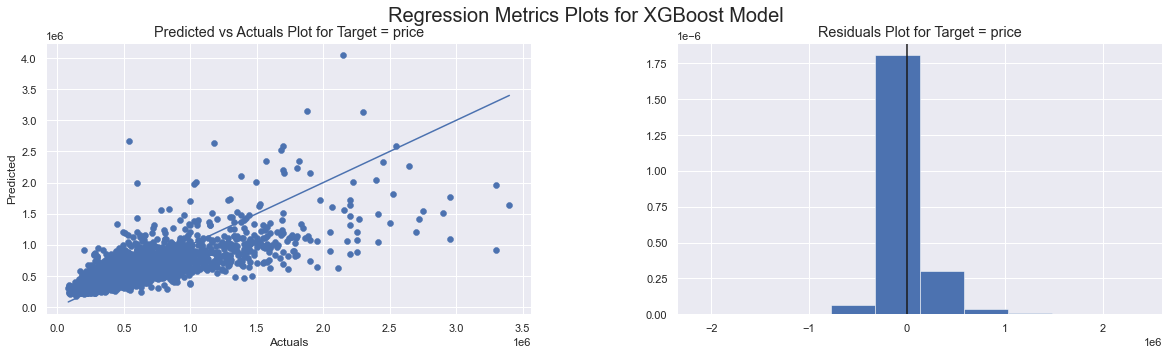

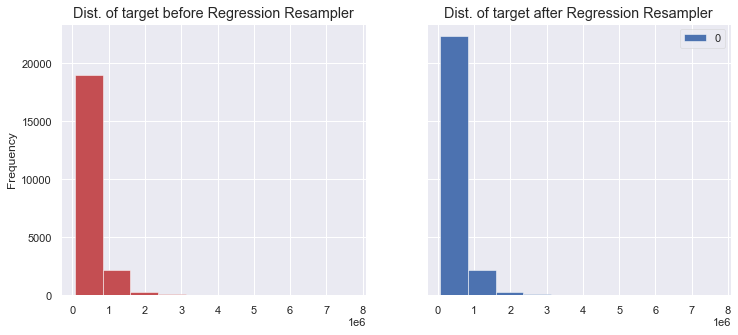

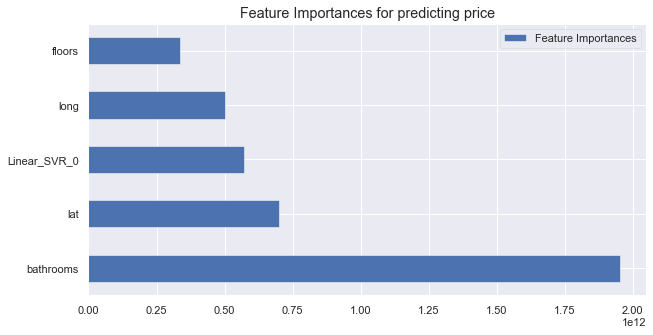

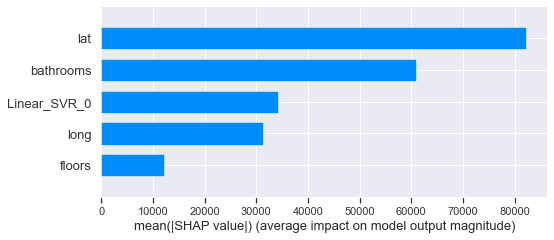

############### P R E D I C T I O N  O N  T E S T   C O M P L E T E D  #################
    Time taken thus far (in seconds) = 25
Writing Output files to disk...
    Saving predictions to .\price\price_Regression_test_modified.csv
    Saving predictions to .\price\price_Regression_submission.csv
    Saving predictions to .\price\price_Regression_train_modified.csv
###############  C O M P L E T E D  ################
Time Taken in mins = 0.4 for the Entire Process


In [11]:
from autoviml.Auto_ViML import Auto_ViML
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Stijnvhd/AutoML_DL_Course/main/Data/kc_house_data.csv')

model, features, trainm, testm = Auto_ViML(
    train=df,
    target="price",
    test="",
    sample_submission="",
    hyper_param="RS",
    feature_reduction=True,
    scoring_parameter="weighted-f1",
    KMeans_Featurizer=False,
    Boosting_Flag=True,
    Binning_Flag=False,
    Add_Poly=False,
    Stacking_Flag=True,
    Imbalanced_Flag=True,
    verbose=3
)

##############  D A T A   S E T  A N A L Y S I S  #######################
Training Set Shape = (891, 11)
    Training Set Memory Usage = 0.06 MB
Single_Label Target: ['Survived']
Random shuffling the data set before training
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
       Class  -> Counts -> Percent
           0:     549  ->   61.6%
           1:     342  ->   38.4%
    Target Survived is already numeric. No transformation done.
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    10 Predictors classified...
        This does not include the Target column(s)
    No variables removed since no ID or low-information variables found in data set
Number of Processors on this device = 1
CPU available
    No GPU active on this device
#############     D A T A    P R E P A R A T I O N   AND C L E A N I N G     #############
No Missing Values in train data set
    Completed La

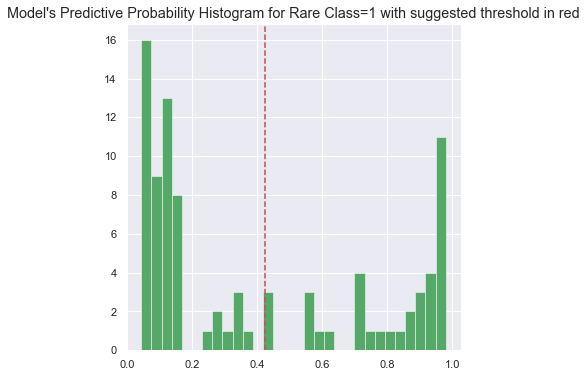

    Using threshold=0.5. However, 0.423 provides better F1=0.83 for rare class...
########################################################
XGBoost Model Prediction Results on Held Out CV Data Set:
    Regular Accuracy Score = 85.6%
Balanced Accuracy = 83.12% with Threshold = 0.50
Confusion Matrix:
[[49  6]
 [ 8 27]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.88        55
           1       0.82      0.77      0.79        35

    accuracy                           0.84        90
   macro avg       0.84      0.83      0.83        90
weighted avg       0.84      0.84      0.84        90

Balanced Accuracy = 85.97% with Threshold = 0.42
Confusion Matrix:
[[49  6]
 [ 6 29]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        55
           1       0.83      0.83      0.83        35

    accuracy                           0.87        90
   macro avg       0.86      0.86      0.86        

Could not plot Model Evaluation Results Metrics
    Time taken for this Target (in seconds) = 2
    Binning_Flag set to False or there are no float vars in data set to be binned
CAUTION: Stacking can produce Highly Overfit models on Training Data...
    Adding 2 Stacking feature(s) to training data
Performing MinMax scaling of train and test data...
#####   T R A I N I N G   M O D E L   O N    F U L L   T R A I N  D A T A  #############
##################  Imbalanced Model Training  ############################
Imbalanced Training using SMOTE Rare Class Oversampling method...
Using SMOTE's over-sampling techniques to make the 2 classes balanced...
    This is not an Imbalanced data set. No need to use SMOTE but continuing...
    class_weights = [0.81147541 1.30263158]
    class_weighted_rows = {0: 549, 1: 445}
Training model now on resampled train data: (994, 11). This will take time...
    Resampled data Training time taken = 0 seconds
##################  Completed Imbalanced Training

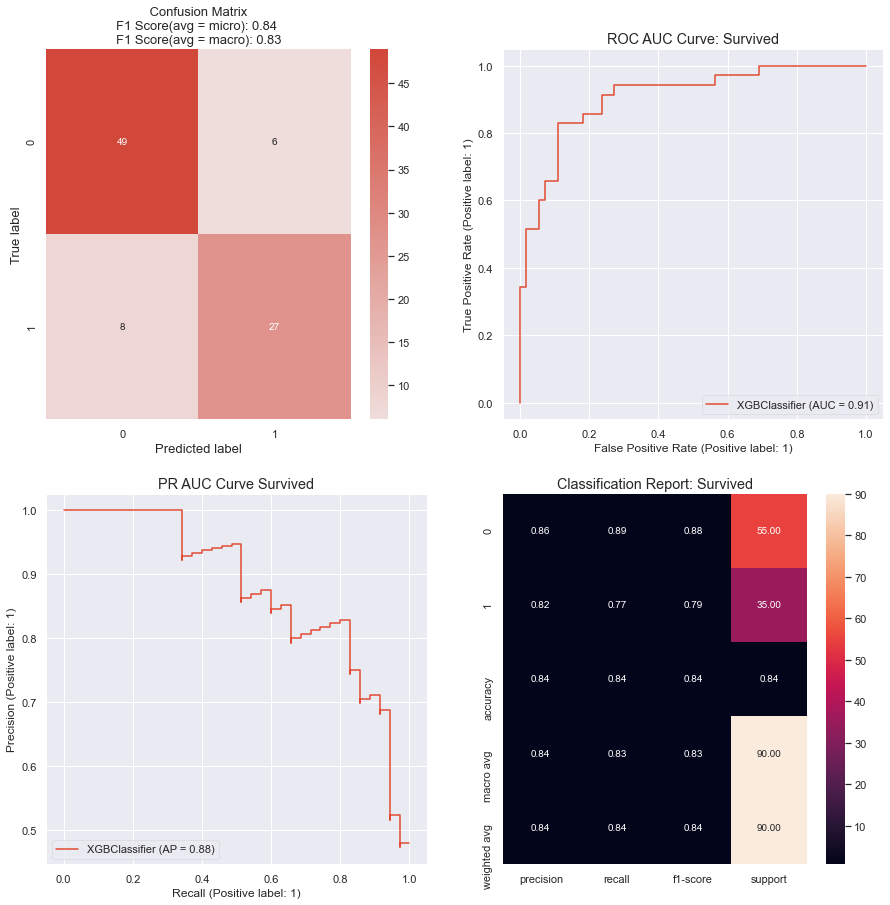

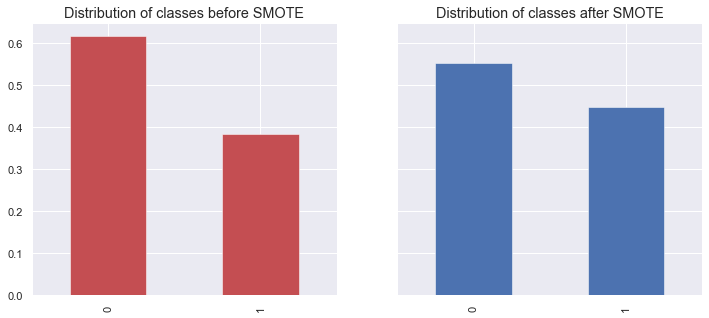

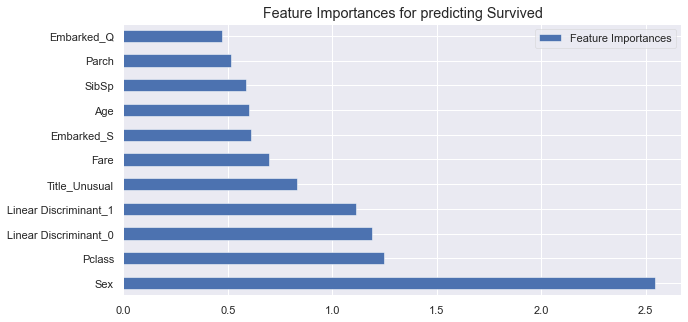

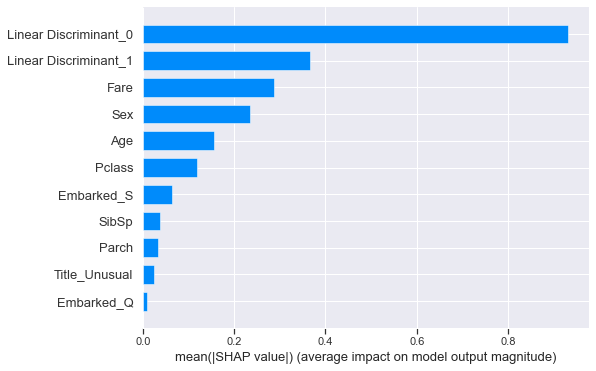

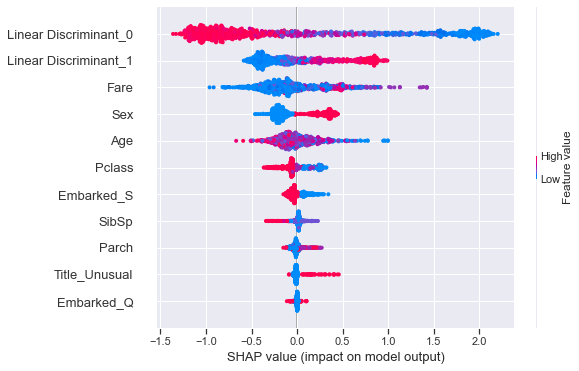

############### P R E D I C T I O N  O N  T E S T   C O M P L E T E D  #################
    Time taken thus far (in seconds) = 5
Writing Output files to disk...
    Saving predictions to .\Survived\Survived_Binary_Classification_test_modified.csv
    Saving predictions to .\Survived\Survived_Binary_Classification_submission.csv
    Saving predictions to .\Survived\Survived_Binary_Classification_train_modified.csv
###############  C O M P L E T E D  ################
Time Taken in mins = 0.1 for the Entire Process


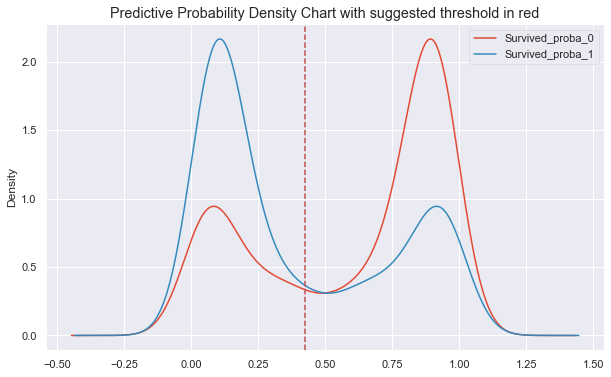

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/Stijnvhd/AutoML_DL_Course/main/Data/titanic_dataset.csv')

df.drop("PassengerId", axis=1, inplace=True)
df.drop('Ticket', axis=1, inplace=True)
gender_mapper = {'male': 0, 'female': 1}
df['Sex'].replace(gender_mapper, inplace=True)
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].strip().split(' ')[0])
df['Title'] = [0 if x in ['Mr.', 'Miss.', 'Mrs.'] else 1 for x in df['Title']]
df = df.rename(columns={'Title': 'Title_Unusual'})
df.drop('Name', axis=1, inplace=True)
df['Cabin_Known'] = [0 if str(x) == 'nan' else 1 for x in df['Cabin']]
df.drop('Cabin', axis=1, inplace=True)
emb_dummies = pd.get_dummies(df['Embarked'], drop_first=True, prefix='Embarked')
df = pd.concat([df, emb_dummies], axis=1)
df.drop('Embarked', axis=1, inplace=True)
df['Age'] = df['Age'].fillna(int(df['Age'].mean()))

model, features, trainm, testm = Auto_ViML(
    train=df,
    target="Survived",
    test="",
    sample_submission="",
    hyper_param="RS",
    feature_reduction=True,
    scoring_parameter="weighted-f1",
    KMeans_Featurizer=False,
    Boosting_Flag=True,
    Binning_Flag=False,
    Add_Poly=False,
    Stacking_Flag=True,
    Imbalanced_Flag=True,
    verbose=3
)